In [ ]:
#|default_exp lit_model

# LitModel
> Lit model API

In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [3]:
#| export
from loguru import logger
from pytorch_lightning.core.lightning import LightningModule
import torch
import torch.nn as nn
from datetime import datetime, timedelta
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
import os
from fastcore.all import *
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
try:
    from lit_classifier.loss import FocalLoss, BinaryFocalLoss
except:
    FocalLoss, BinaryFocalLoss = None, None
    logger.warning('Install mmcv-full if you wish to use FocalLoss')
import os.path as osp
from torch.optim.lr_scheduler import LambdaLR

/home/anhvth/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Schedulers

In [4]:
#| export
from timm.scheduler.cosine_lr import CosineLRScheduler, Scheduler

# def get_optim_cfg(type='linear', 
#                   epochs, num_steps_per_epoch, 
#                   lr=1e-3, init_lr=0.5, min_lr=0.2, 
#                   interval='step', optim='Adam', num_cycle=3, 
#                   cycle_decay=0.8, **kwargs):
    
#     steps = epochs*num_steps_per_epoch
#     num_epochs_per_cycle = int(epochs/num_cycle)
    
#     return dict(init_lr=init_lr, 
#                 min_lr=min_lr,
#                 steps=steps,
#                 epochs=epochs,
#                 interval=interval,
#                 optim=optim, 
#                 num_epochs_per_cycle=num_epochs_per_cycle,
#                 num_steps_per_epoch=num_steps_per_epoch, **kwargs)
def plot_lr_step_schedule(fn, lr, num_epochs, num_steps_per_epoch):
    import matplotlib.pyplot as plt
    lrs = []
    steps = num_epochs*num_steps_per_epoch
    for step in range(steps):
        lrs.append(fn(step)*lr)
    print(f'{min(lrs)=:0.5f}, {max(lrs)=:0.5f}')
    plt.plot(range(steps),lrs)
    plt.show()

def fn_schedule_linear_with_warmup(num_epochs, num_steps_per_epoch, 
                                   num_warmup_steps=0, init_lr=0.4, min_lr=0.1):
    num_training_steps = num_epochs*num_steps_per_epoch
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            x = (1-init_lr)*(current_step / num_warmup_steps)+init_lr
            return x

        total_step = (num_training_steps-num_warmup_steps)
        current_step = current_step-num_warmup_steps
        rt = min_lr+(1-min_lr)*(1-current_step/total_step)
        return rt
    return lr_lambda


def fn_schedule_cosine_with_warmpup_decay_timm(num_epochs, num_steps_per_epoch, num_epochs_per_cycle, 
                                   num_warmup_epochs=1, init_lr=0.4, min_lr=0.1, cycle_decay=.8, interval='step'):
    lr = 1
    num_cycles = num_epochs // num_epochs_per_cycle
    optim = torch.optim.SGD(nn.Linear(1,1).parameters(), lr)
    m = 1 if interval == 'epoch' else num_steps_per_epoch
    logger.info(f'{num_cycles=}')
    schedule = CosineLRScheduler(optim, 
                                 t_initial=num_epochs_per_cycle*m,
                                 lr_min=min_lr*lr, 
                                 cycle_decay=cycle_decay,
                                 cycle_limit=num_cycles,warmup_t=num_warmup_epochs*m,warmup_lr_init=init_lr*lr,
                                )
    get_lr = lambda step: schedule._get_lr(step)[0]
    return get_lr
    

def get_scheduler(optimizer, lr_schedule_fn, interval='step', verbose=False):
    scheduler = {
        "scheduler": LambdaLR(optimizer, lr_schedule_fn, -1, verbose=verbose),
        "interval": interval, 
        "frequency": 1,
    }
    return scheduler

2022-07-31 13:23:56.651 | INFO     | __main__:fn_schedule_cosine_with_warmpup_decay_timm:52 - num_cycles=3


min(lrs)=0.01000, max(lrs)=0.09800


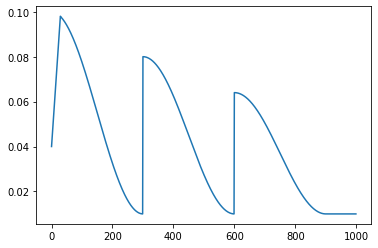

In [5]:

fn = fn_schedule_cosine_with_warmpup_decay_timm(100, 10, 30, 3)
plot_lr_step_schedule(fn, 0.1, 100, 10)

In [6]:
# get_scheduler()

## LitModel

In [7]:
fn_schedule_cosine_with_warmpup_decay_timm?

Signature:
fn_schedule_cosine_with_warmpup_decay_timm(
    num_epochs,
    num_steps_per_epoch,
    num_epochs_per_cycle,
    num_warmup_epochs=1,
    init_lr=0.4,
    min_lr=0.1,
    cycle_decay=0.8,
    interval='step',
)
Docstring: <no docstring>
File:      /tmp/ipykernel_19628/1125565782.py
Type:      function


In [8]:
#| export
class LitModel(LightningModule):
    
    def __init__(self, model, 
                 # lr_schdule_cfg=dict(type='cosine', train_loader=None), 
                 create_optimizer_fn=None, 
                 create_lr_scheduler_fn=None,
                 loss_fn=nn.CrossEntropyLoss()):
        
        super().__init__()
        store_attr()
    
    def configure_optimizers(self):
        """
            Setup optimizer and scheduler
        """
        assert self.create_optimizer_fn is not None            
        
        optimizer = self.create_optimizer_fn(self.model.parameters())
        scheduler = get_scheduler(optimizer, self.create_lr_scheduler_fn)
        return [optimizer], [scheduler]


    def forward(self, x):
        return self.model(x)

    def validation_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.softmax(1).argmax(1)
        accs = (y == preds).float().mean()
        self.log("val_loss", loss, rank_zero_only=True, prog_bar=True,
                    on_step=False, on_epoch=True)
        self.log("val_acc", accs, rank_zero_only=True, prog_bar=True,
                    on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.softmax(1).argmax(1)
        accs = (y == preds).float().mean()
        
        self.log("training_loss", loss, prog_bar=True, rank_zero_only=True, on_epoch=True)
        self.log("training_accuracy", accs, prog_bar=True, rank_zero_only=True, on_epoch=True)
        return loss

## Get trainer

In [9]:
#| export
def get_trainer(exp_name, gpus=1, max_epochs=None, distributed=False,
        monitor=dict(metric="val_acc", mode="max"), save_every_n_epochs=1, save_top_k=1, use_version=True,
    trainer_kwargs=dict()):
    if max_epochs is None:
        assert optim_cfg is not None, f'optim_cfg and max_epoch cannot be both None'
        max_epochs = optim_cfg['epochs']
        
    
    root_log_dir = osp.join(
            "lightning_logs", exp_name)
    
    cur_num_exps = len(os.listdir(root_log_dir)) if osp.exists(root_log_dir) else 0
    version = f"{cur_num_exps:02d}"
    
    if use_version:
        root_log_dir = osp.join(root_log_dir, version)
        logger.info('Root log directory: {}'.format(root_log_dir))
        
    filename="{epoch}-{"+monitor["metric"]+":.2f}"

    callback_ckpt = ModelCheckpoint(
        dirpath=osp.join(root_log_dir, "ckpts"),
        monitor=monitor['metric'],mode=monitor['mode'],
        filename=filename,
        save_last=True,
        every_n_epochs=save_every_n_epochs,
        save_top_k=save_top_k,
    )

    callback_tqdm = TQDMProgressBar(refresh_rate=5)
    callback_lrmornitor = LearningRateMonitor(logging_interval="step")
    plt_logger = TensorBoardLogger(
        osp.join(root_log_dir, "tb_logs"), version=version
    )
    
    trainer = Trainer(
        gpus=gpus,
        max_epochs=max_epochs,
        strategy= "dp" if not distributed else "ddp",
        callbacks=[callback_ckpt, callback_tqdm, callback_lrmornitor],
        logger=plt_logger,**trainer_kwargs,
    )
    return trainer

In [10]:
#|hide


# Mnist example 

In [11]:
#hide
import os

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
import pytorch_lightning as pl

BATCH_SIZE = 256 #if AVAIL_GPUS else 64

from timm.data.transforms_factory import transforms_imagenet_train, transforms_imagenet_eval


def to_rgb(x):
    return x.convert('RGB')
train_transform = transforms.Compose(
    [
        transforms.Lambda(to_rgb),
        *transforms_imagenet_train(32).transforms,
    ]
)
class ClassifierDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./", batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage):
        self.mnist_test = MNIST(self.data_dir, train=False, transform=train_transform)
        self.mnist_predict = MNIST(self.data_dir, train=False, transform=train_transform)
        mnist_full = MNIST(self.data_dir, train=True, transform=train_transform)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=self.batch_size)

    # def teardown(self, stage: Optional[str] = None):
        # Used to clean-up when the run is finished
# mnist = MNISTDataModule()

In [4]:
# # Init DataLoader from MNIST Dataset
# from timm.data.transforms_factory import transforms_imagenet_train, transforms_imagenet_eval

# T = transforms.Compose(
# [    
#     transforms.Lambda(to_rgb),
#     *transforms_imagenet_eval(32).transforms,
# ]
# )

# train_ds = MNIST(root='./', train=True, download=True, transform=T)
# test_ds = MNIST(root='./', train=False, download=True, transform=T)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=4)
# test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE*2, num_workers=4)

In [5]:
# [m for m in timm.list_models() if 'mobile' in m]

In [6]:
# #| hide
# import torch.nn as nn
# import timm

# model = timm.create_model('mobilenetv2_035', True, num_classes=10)
# num_epochs = 10

# steps_per_epoch = len(train_loader)
# optim_sche = fn_schedule_cosine_with_warmpup_decay_timm(num_epochs, steps_per_epoch, num_epochs//3, 1)
# create_optim = lambda params: torch.optim.Adam(params, lr=0.15)

# trainer = get_trainer('test', gpus=[0], 
#                       distributed=False, max_epochs=num_epochs,
#                      trainer_kwargs=dict(
#                          check_val_every_n_epoch=3,
#                      ))

# lit_model = LitModel(model, dict(type='cosine', train_loader=train_loader, num_epochs_per_cycle=3), create_optim)
# lr_finder = trainer.fit(lit_model, train_loader, test_loader)

In [2]:
# trainer.

# Export

In [10]:
from nbdev import nbdev_export
nbdev_export()